<a href="https://colab.research.google.com/github/jdu8/sentiment-analysis-comparison/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Fri Nov 18 05:31:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kazanova/sentiment140

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 79.0M/80.9M [00:04<00:00, 25.5MB/s]
100% 80.9M/80.9M [00:04<00:00, 19.1MB/s]


In [ ]:
! unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Dropout,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding,Bidirectional,LSTM
import keras

In [ ]:
df=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
columns=df.columns
columns

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [ ]:
df.drop([1,2,3,4],axis=1,inplace=True)
df.head()

,0,5
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.columns=['sentiment','data']
df.head()

,sentiment,data
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
y=df['sentiment']

In [ ]:
df_train,df_test,y_train,y_test=train_test_split(df['data'],y,test_size=0.3)
print('DF Train Shape: ',df_train.shape)
print('DF Test Shape: ',df_test.shape)
print('Y Train Shape: ',y_train.shape)
print('Y Test Shape: ',y_test.shape)

DF Train Shape:  (1120000,)
DF Test Shape:  (480000,)
Y Train Shape:  (1120000,)
Y Test Shape:  (480000,)


In [ ]:
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(df_train)
sequence_train=tokenizer.texts_to_sequences(df_train)
sequence_test=tokenizer.texts_to_sequences(df_test)

In [ ]:
word2vec=tokenizer.word_index
V=len(word2vec)
print(f'Number of independent tokens in dataset: {V}')

Number of independent tokens in dataset: 543884


In [ ]:
data_train=pad_sequences(sequence_train)
data_train.shape

(1120000, 116)

In [ ]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(480000, 116)

In [ ]:
D=100
EPOCHS=5
BATCH_SIZE=128

In [ ]:
cnn_model=keras.Sequential([
    Input((T,)),
    Embedding(V+1,D),
    Conv1D(32,3,activation='relu'),
    MaxPooling1D(3),
    Conv1D(64,3,activation='relu'),
    MaxPooling1D(3),
    Conv1D(128,3,activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.4),
    Dense(5,activation='softmax')
])
cnn_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 116, 100)          54388500  
                                                                 
 conv1d (Conv1D)             (None, 114, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 128)           2

In [ ]:
lstm_model=keras.Sequential([
    Input((T,)),
    Embedding(V+1,D),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(5,activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 116, 100)          54388500  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                      

In [ ]:
multi_layer_lstm_model=keras.Sequential([
    Input((T,)),
    Embedding(V+1,D),
    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(5,activation='softmax')
])
multi_layer_lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
multi_layer_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 116, 100)          54388500  
                                                                 
 bidirectional_1 (Bidirectio  (None, 116, 128)         84480     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [ ]:
cnn_lstm_model=keras.Sequential([
    Input((T,)),
    Embedding(V+1,D),
    Conv1D(32,3,activation='relu'),
    MaxPooling1D(3),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(5,activation='softmax')
])
cnn_lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 116, 100)          54388500  
                                                                 
 conv1d_3 (Conv1D)           (None, 114, 32)           9632      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 38, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [ ]:
cnn_multi_layer_lstm_model=keras.Sequential([
    Input((T,)),
    Embedding(V+1,D),
    Conv1D(32,3,activation='relu'),
    MaxPooling1D(3),
    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(5,activation='softmax')
])
cnn_multi_layer_lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_multi_layer_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 116, 100)          54388500  
                                                                 
 conv1d_4 (Conv1D)           (None, 114, 32)           9632      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 38, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_4 (Bidirectio  (None, 38, 128)          49664     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                      

In [ ]:
class CNN_Saver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
          self.model.save(f"model/cnn/cnn_model_{epoch}.h5")
cnn_hist=cnn_model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[CNN_Saver()])

Epoch 1/5
   5/8750 [..............................] - ETA: 4:44 - loss: 1.5603 - accuracy: 0.4609

8750/8750 [==============================] - 306s 34ms/step - loss: 0.4359 - accuracy: 0.7991 - val_loss: 0.4008 - val_accuracy: 0.8173
Epoch 2/5
8750/8750 [==============================] - 299s 34ms/step - loss: 0.3883 - accuracy: 0.8269 - val_loss: 0.3927 - val_accuracy: 0.8221
Epoch 3/5
8750/8750 [==============================] - 298s 34ms/step - loss: 0.3637 - accuracy: 0.8401 - val_loss: 0.4025 - val_accuracy: 0.8181
Epoch 4/5
8750/8750 [==============================] - 294s 34ms/step - loss: 0.3413 - accuracy: 0.8519 - val_loss: 0.4069 - val_accuracy: 0.8209
Epoch 5/5
8750/8750 [==============================] - 298s 34ms/step - loss: 0.3201 - accuracy: 0.8629 - val_loss: 0.4178 - val_accuracy: 0.8163


In [ ]:
class LSTM_Saver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
          self.model.save(f"model/lstm/lstm_model_{epoch}.h5")
lstm_hist=lstm_model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[LSTM_Saver()])

Epoch 1/5
8750/8750 [==============================] - 397s 45ms/step - loss: 0.4335 - accuracy: 0.8006 - val_loss: 0.4019 - val_accuracy: 0.8184
Epoch 2/5
8750/8750 [==============================] - 392s 45ms/step - loss: 0.3904 - accuracy: 0.8251 - val_loss: 0.3880 - val_accuracy: 0.8239
Epoch 3/5
8750/8750 [==============================] - 392s 45ms/step - loss: 0.3731 - accuracy: 0.8341 - val_loss: 0.3916 - val_accuracy: 0.8238
Epoch 4/5
8750/8750 [==============================] - 392s 45ms/step - loss: 0.3581 - accuracy: 0.8420 - val_loss: 0.3865 - val_accuracy: 0.8271
Epoch 5/5
8750/8750 [==============================] - 392s 45ms/step - loss: 0.3443 - accuracy: 0.8491 - val_loss: 0.3899 - val_accuracy: 0.8245


In [ ]:
class Multi_Layer_LSTM_Saver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
          self.model.save(f"model/multi_layer_lstm/multi_layer_lstm_model_{epoch}.h5")
multi_layer_lstm_hist=multi_layer_lstm_model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[Multi_Layer_LSTM_Saver()])

Epoch 1/5
8750/8750 [==============================] - 557s 63ms/step - loss: 0.4307 - accuracy: 0.8020 - val_loss: 0.3961 - val_accuracy: 0.8198
Epoch 2/5
8750/8750 [==============================] - 550s 63ms/step - loss: 0.3858 - accuracy: 0.8278 - val_loss: 0.3847 - val_accuracy: 0.8260
Epoch 3/5
8750/8750 [==============================] - 550s 63ms/step - loss: 0.3646 - accuracy: 0.8387 - val_loss: 0.3810 - val_accuracy: 0.8289
Epoch 4/5
8750/8750 [==============================] - 546s 62ms/step - loss: 0.3458 - accuracy: 0.8482 - val_loss: 0.3881 - val_accuracy: 0.8274
Epoch 5/5
8750/8750 [==============================] - 550s 63ms/step - loss: 0.3270 - accuracy: 0.8580 - val_loss: 0.3916 - val_accuracy: 0.8271


In [ ]:
class CNN_LSTM_Saver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
          self.model.save(f"model/cnn_lstm/cnn_lstm_model_{epoch}.h5")
cnn_lstm_hist=cnn_lstm_model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[CNN_LSTM_Saver()])

Epoch 1/5
8750/8750 [==============================] - 359s 41ms/step - loss: 0.4355 - accuracy: 0.7986 - val_loss: 0.3975 - val_accuracy: 0.8184
Epoch 2/5
8750/8750 [==============================] - 353s 40ms/step - loss: 0.3847 - accuracy: 0.8283 - val_loss: 0.3902 - val_accuracy: 0.8226
Epoch 3/5
8750/8750 [==============================] - 353s 40ms/step - loss: 0.3611 - accuracy: 0.8409 - val_loss: 0.4002 - val_accuracy: 0.8228
Epoch 4/5
8750/8750 [==============================] - 360s 41ms/step - loss: 0.3396 - accuracy: 0.8521 - val_loss: 0.4012 - val_accuracy: 0.8205
Epoch 5/5
8750/8750 [==============================] - 360s 41ms/step - loss: 0.3190 - accuracy: 0.8625 - val_loss: 0.4172 - val_accuracy: 0.8182


In [ ]:
class CNN_Multi_Layer_LSTM_Saver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
          self.model.save(f"model/cnn_multi_layer_lstm/cnn_multi_layer_lstm_model_{epoch}.h5")
cnn_multi_layer_lstm_hist=cnn_multi_layer_lstm_model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[CNN_Multi_Layer_LSTM_Saver()])

Epoch 1/5
8750/8750 [==============================] - 383s 43ms/step - loss: 0.4332 - accuracy: 0.7999 - val_loss: 0.3954 - val_accuracy: 0.8207
Epoch 2/5
8750/8750 [==============================] - 375s 43ms/step - loss: 0.3818 - accuracy: 0.8303 - val_loss: 0.3883 - val_accuracy: 0.8243
Epoch 3/5
8750/8750 [==============================] - 377s 43ms/step - loss: 0.3573 - accuracy: 0.8431 - val_loss: 0.3904 - val_accuracy: 0.8239
Epoch 4/5
8750/8750 [==============================] - 378s 43ms/step - loss: 0.3350 - accuracy: 0.8549 - val_loss: 0.3985 - val_accuracy: 0.8233
Epoch 5/5
8750/8750 [==============================] - 379s 43ms/step - loss: 0.3138 - accuracy: 0.8653 - val_loss: 0.4098 - val_accuracy: 0.8198


In [ ]:
print(cnn_hist.history)

{'loss': [0.4359154999256134, 0.38826215267181396, 0.36372384428977966, 0.341311514377594, 0.32006144523620605], 'accuracy': [0.7990696430206299, 0.8268625140190125, 0.8401491045951843, 0.8518642783164978, 0.8628767728805542], 'val_loss': [0.4007611572742462, 0.39272356033325195, 0.40248507261276245, 0.40692880749702454, 0.4177767336368561], 'val_accuracy': [0.8173041939735413, 0.8220875263214111, 0.8180916905403137, 0.8208708167076111, 0.8162500262260437]}


In [ ]:
print(lstm_hist.history)

{'loss': [0.4335056245326996, 0.39036664366722107, 0.37310975790023804, 0.3581339716911316, 0.3443062901496887], 'accuracy': [0.8005883693695068, 0.8251339197158813, 0.8340562582015991, 0.8419767618179321, 0.8490607142448425], 'val_loss': [0.4018900692462921, 0.3879840672016144, 0.3915782570838928, 0.3865244686603546, 0.38991281390190125], 'val_accuracy': [0.8183521032333374, 0.823870837688446, 0.8238208293914795, 0.8271104097366333, 0.8245499730110168]}


In [ ]:
print(multi_layer_lstm_hist.history)

{'loss': [0.4306972920894623, 0.38582509756088257, 0.36464065313339233, 0.3457568883895874, 0.3269653022289276], 'accuracy': [0.8019955158233643, 0.8277946710586548, 0.8387482166290283, 0.848209798336029, 0.8579776883125305], 'val_loss': [0.3961445689201355, 0.3846712112426758, 0.3809850215911865, 0.38805171847343445, 0.39161932468414307], 'val_accuracy': [0.8197708129882812, 0.825977087020874, 0.8288770914077759, 0.8274291753768921, 0.8271104097366333]}


In [ ]:
print(cnn_lstm_hist.history)

{'loss': [0.4354543387889862, 0.3846949636936188, 0.3610617220401764, 0.3396070599555969, 0.3189971446990967], 'accuracy': [0.7986428737640381, 0.828342854976654, 0.840916097164154, 0.8520955443382263, 0.8625205159187317], 'val_loss': [0.3974927067756653, 0.390211284160614, 0.40016046166419983, 0.40118855237960815, 0.4171736240386963], 'val_accuracy': [0.8183687329292297, 0.822616696357727, 0.8227999806404114, 0.8204770684242249, 0.818206250667572]}


In [ ]:
print(cnn_multi_layer_lstm_hist.history)

{'loss': [0.4331967234611511, 0.3817761242389679, 0.35726499557495117, 0.3349849581718445, 0.31381693482398987], 'accuracy': [0.7998562455177307, 0.8302660584449768, 0.8431044816970825, 0.8548741340637207, 0.8652634024620056], 'val_loss': [0.3954436182975769, 0.3882535994052887, 0.39043495059013367, 0.39854514598846436, 0.40982213616371155], 'val_accuracy': [0.8206562399864197, 0.8243083357810974, 0.8239166736602783, 0.8233187794685364, 0.8198021054267883]}


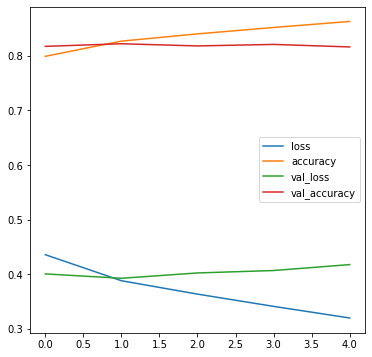

In [12]:
pd.DataFrame(cnn_hist.history).plot(figsize=(6,6))

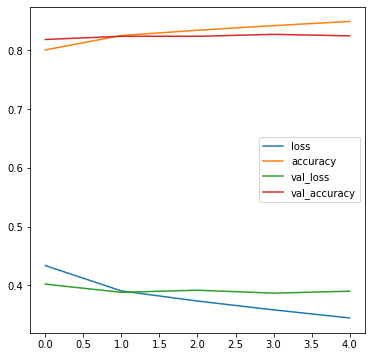

In [15]:
pd.DataFrame(lstm_hist.history).plot(figsize=(6,6))

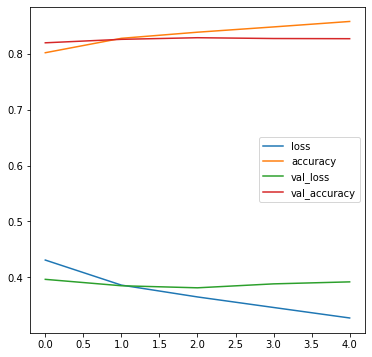

In [14]:
pd.DataFrame(multi_layer_lstm_hist.history).plot(figsize=(6,6))

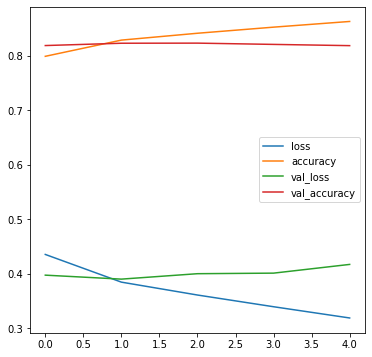

In [16]:
pd.DataFrame(cnn_lstm_hist.history).plot(figsize=(6,6))

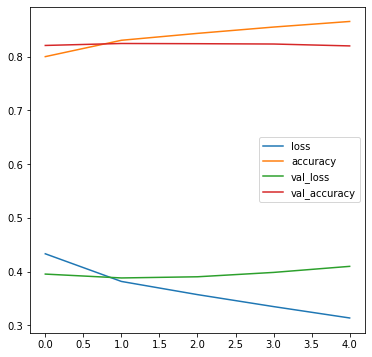

In [17]:
pd.DataFrame(cnn_multi_layer_hist.history).plot(figsize=(6,6))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir -p content/drive/MyDrive/Sample

In [ ]:
! cp -r model/ drive/MyDrive/Sample/